In [24]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
elec_path='data/eaglei_data/'
storm_path='data/NOAA_StormEvents/'

In [11]:
history = pd.read_csv(elec_path+'coverage_history.csv')
history


,year,state,total_customers,min_covered,max_covered,min_pct_covered,max_pct_covered
0,1/1/18,AK,340543,229424,229424,0.67,0.67
1,1/1/19,AK,340543,217506,229424,0.64,0.67
2,1/1/20,AK,328964,158477,224243,0.48,0.68
3,1/1/21,AK,331443,224243,226079,0.68,0.68
4,1/1/22,AK,364614,226079,258830,0.62,0.71
...,...,...,...,...,...,...,...
275,1/1/18,WY,339370,211190,211190,0.62,0.62
276,1/1/19,WY,339370,199512,229576,0.59,0.68
277,1/1/20,WY,325946,213717,230825,0.66,0.71
278,1/1/21,WY,328728,230825,232248,0.70,0.71


In [12]:
eaglei_2014=pd.read_csv(elec_path+'eaglei_outages_2014.csv')
eaglei_2015=pd.read_csv(elec_path+'eaglei_outages_2015.csv')
eaglei_2016=pd.read_csv(elec_path+'eaglei_outages_2016.csv')
eaglei_2017=pd.read_csv(elec_path+'eaglei_outages_2017.csv')
eaglei_2018=pd.read_csv(elec_path+'eaglei_outages_2018.csv')
eaglei_2019=pd.read_csv(elec_path+'eaglei_outages_2019.csv')
eaglei_2020=pd.read_csv(elec_path+'eaglei_outages_2020.csv')
eaglei_2021=pd.read_csv(elec_path+'eaglei_outages_2021.csv')
eaglei_2022=pd.read_csv(elec_path+'eaglei_outages_2022.csv')
eaglei_2023=pd.read_csv(elec_path+'eaglei_outages_2023.csv')


In [29]:
eaglei_2014=pd.read_csv(elec_path+'eaglei_outages_2014.csv')
eaglei_2014

,fips_code,county,state,customers_out,run_start_time
0,1037,Coosa,Alabama,12,2014-11-01 04:00:00
1,1051,Elmore,Alabama,7,2014-11-01 04:00:00
2,1109,Pike,Alabama,1,2014-11-01 04:00:00
3,1121,Talladega,Alabama,31,2014-11-01 04:00:00
4,4017,Navajo,Arizona,1,2014-11-01 04:00:00
...,...,...,...,...,...
1689455,55029,Door,Wisconsin,1,2014-12-31 00:00:00
1689456,55079,Milwaukee,Wisconsin,1,2014-12-31 00:00:00
1689457,55093,Pierce,Wisconsin,6,2014-12-31 00:00:00
1689458,55125,Vilas,Wisconsin,6,2014-12-31 00:00:00


In [25]:
def create_daily_aggregated_df(years):
    """
    Function to aggregate customers_out by day for each year and concatenate the results.
    
    Parameters:
    years (list): List of years to process (e.g., [2014, 2015, ..., 2023])
    
    Returns:
    pd.DataFrame: Concatenated DataFrame with daily aggregated customers_out for all years
    """
    # List to store each year's aggregated DataFrame
    dfs = []
    
    # Process each year
    for year in years:
        print(f"Processing year {year}...")
        
        # Step 1: Load the data for the year
        file_path = f'eaglei_outages_{year}.csv'
        try:
            df = pd.read_csv(elec_path+file_path)
        except FileNotFoundError:
            print(f"File for year {year} not found. Skipping...")
            continue
        
        # Step 2: Convert run_start_time to datetime
        df['run_start_time'] = pd.to_datetime(df['run_start_time'])
        
        # Step 3: Set run_start_time as the index for resampling
        df.set_index('run_start_time', inplace=True)
        
        # Step 4: Resample by day and sum customers_out
        df_daily = df['customers_out'].resample('D').sum().reset_index()
        
        # Step 5: Add a 'year' column to identify the year
        df_daily['year'] = year
        
        # Append the resampled DataFrame to the list
        dfs.append(df_daily)
    
    # Step 6: Concatenate all DataFrames
    if not dfs:
        raise ValueError("No data was processed. Check if the files exist.")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Step 7: Rename columns for clarity
    combined_df.columns = ['date', 'customers_out', 'year']
    
    return combined_df

# Example usage:
years = range(2014, 2024)  # Years 2014 to 2023
daily_aggregated_df = create_daily_aggregated_df(years)

Processing year 2014...
Processing year 2015...


KeyboardInterrupt: 

In [22]:
daily_aggregated_df 

,date,customers_out,year
0,2014-11-01,7174448.0,2014
1,2014-11-02,7315424.0,2014
2,2014-11-03,14222724.0,2014
3,2014-11-04,9052045.0,2014
4,2014-11-05,5110035.0,2014
...,...,...,...
3343,2023-12-27,4996723.0,2023
3344,2023-12-28,5027591.0,2023
3345,2023-12-29,2731506.0,2023
3346,2023-12-30,2233781.0,2023


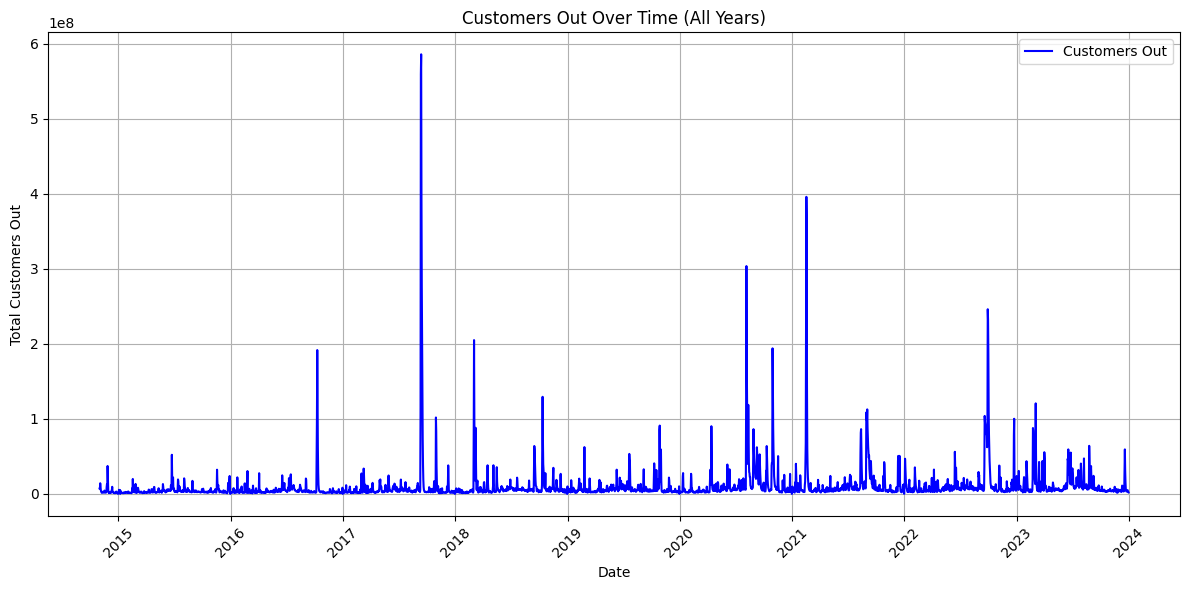

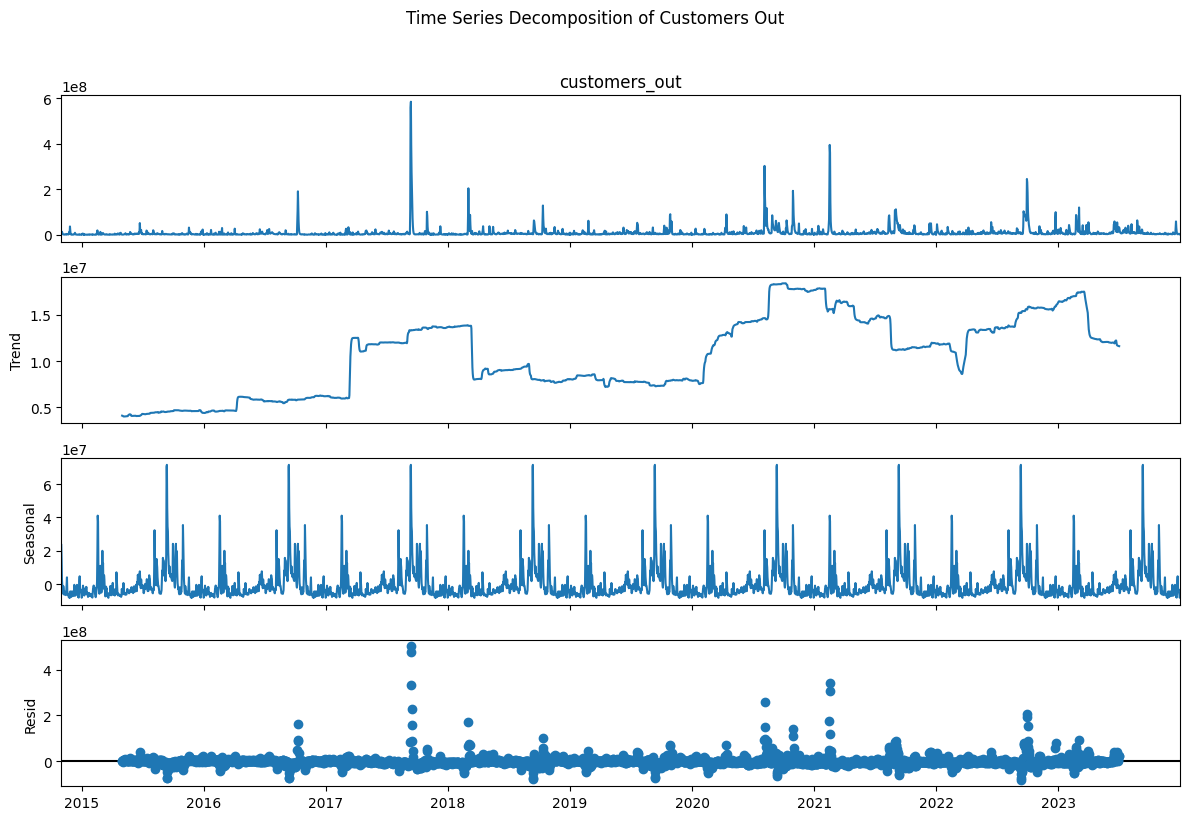

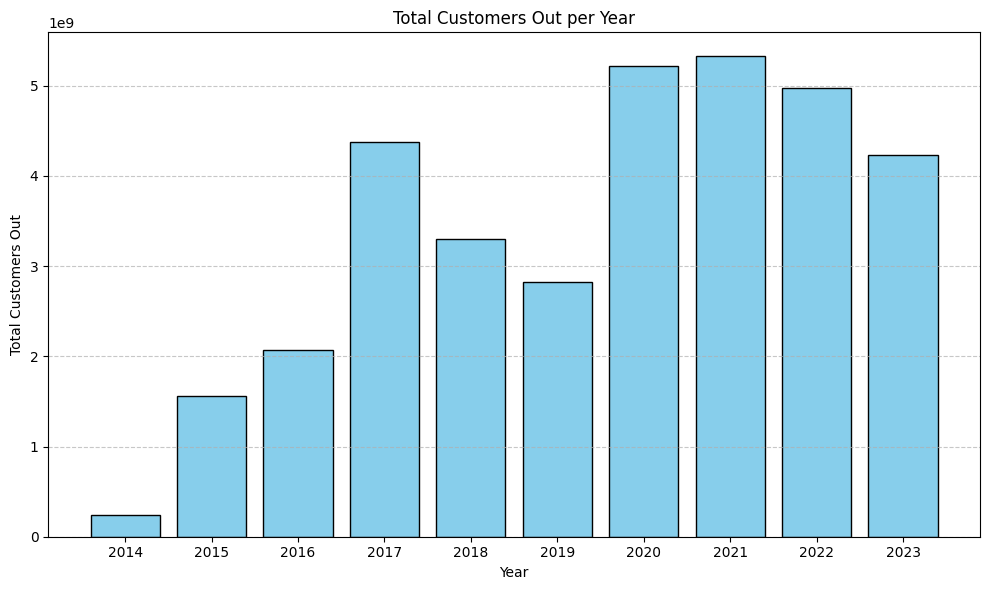

In [27]:

# Assuming daily_aggregated_df is already created from the previous function
# For demonstration, let's assume daily_aggregated_df exists with columns: date, customers_out, year

# Plot 1: Line Plot of customers_out vs date (all years combined)
plt.figure(figsize=(12, 6))
plt.plot(daily_aggregated_df['date'], daily_aggregated_df['customers_out'], label='Customers Out', color='blue')
plt.title('Customers Out Over Time (All Years)')
plt.xlabel('Date')
plt.ylabel('Total Customers Out')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Time Series Decomposition Plot
# Prepare the data for decomposition (needs a datetime index)
decomp_df = daily_aggregated_df.set_index('date')['customers_out']

# Perform decomposition (assuming a yearly seasonality, period=365 days)
decomposition = seasonal_decompose(decomp_df, model='additive', period=365)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition of Customers Out', y=1.02)
plt.tight_layout()
plt.show()

# Plot 3: Yearly Summary Plot (Subplots for each year)
yearly_sum = daily_aggregated_df.groupby('year')['customers_out'].sum().reset_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(yearly_sum['year'], yearly_sum['customers_out'], color='skyblue', edgecolor='black')
plt.title('Total Customers Out per Year')
plt.xlabel('Year')
plt.ylabel('Total Customers Out')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_sum['year'])  # Ensure all years are shown on the x-axis
plt.tight_layout()
plt.show()


In [14]:
MCC=pd.read_csv(elec_path+'MCC.csv')
MCC

,County_FIPS,Customers
0,1001,24619
1,1003,195253
2,1005,12400
3,1007,11037
4,1009,27074
...,...,...
3229,72153,15251
3230,78010,30899
3231,78020,2683
3232,78030,22725


In [31]:
csv_files = glob.glob(storm_path + "StormEvents_details-*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
storms_df = pd.concat(df_list, ignore_index=True)
storms_df

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201402,18,1000,201402,18,2000,83473,503953,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure developing south of Long Island a...,Eight to twelve inches of snow fell across eas...,CSV
1,201402,5,300,201402,5,2300,83491,504065,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moving off the mid-Atlantic coast...,Six to twelve inches of snow fell across easte...,CSV
2,201401,18,1000,201401,19,700,82185,494521,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure brought a brief period of heavy s...,Four to eight inches of snow fell across easte...,CSV
3,201411,26,1000,201411,27,1000,91728,549746,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong coastal storm moved up the east coast...,Six to eight inches of snow fell across easter...,CSV
4,201402,13,630,201402,14,800,83476,503982,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A significant winter storm brought six to twel...,Five to eight inches of snow fell across easte...,CSV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691429,202008,10,845,202008,10,845,150384,919277,IOWA,19,...,0.0,N,SAC CITY,42.4200,-95.0000,42.4200,-95.0000,Basic Summary: A cluster of storms in northeas...,No LSRs were transmitted from within the count...,CSV
691430,202006,2,1402,202006,2,1405,148832,904958,KANSAS,20,...,3.0,S,SHARON SPGS ARPT,38.8031,-101.7521,38.8111,-101.7496,A weak landspout tornado was reported in Walla...,Brief landspout tornado observed south of Shar...,CSV
691431,202006,8,2337,202006,8,2337,149983,904282,COLORADO,8,...,6.0,WSW,CLARKVILLE,40.3491,-102.7176,40.3491,-102.7176,Around midnight a northward moving thunderstor...,Unknown number of power poles near the interse...,CSV
691432,202006,2,1723,202006,2,1723,148836,896642,NEBRASKA,31,...,3.0,WSW,PALISADE,40.3355,-101.1506,40.3355,-101.1506,A cluster of thunderstorms extended south into...,Also came with estimated gusts of 70 MPH that ...,CSV


In [ ]:
storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df['BEGIN_DATE_TIME'])
storms_df['storm_date'] = storms_df['BEGIN_DATE_TIME'].dt.date  # Extract date part (e.g., 2014-11-01)

# Ensure daily_aggregated_df['date'] is in datetime.date format for merging
daily_aggregated_df['date'] = pd.to_datetime(daily_aggregated_df['date']).dt.date

# Step 3: Merge the DataFrames on the date column
# Left merge: keep all rows from daily_aggregated_df, and match storm events where possible
merged_df = pd.merge(
    daily_aggregated_df,
    storms_df,
    left_on='date',
    right_on='storm_date',
    how='left'
)

# Step 4: Drop the temporary storm_date column (optional, if you don't need it)
merged_df = merged_df.drop(columns=['storm_date'], errors='ignore')



/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_87525/113545702.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df['BEGIN_DATE_TIME'])


         date  customers_out  year  BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  \
0  2014-11-01      7174448.0  2014           201411          1           0   
1  2014-11-01      7174448.0  2014           201411          1           0   
2  2014-11-01      7174448.0  2014           201411          1           0   
3  2014-11-01      7174448.0  2014           201411          1           0   
4  2014-11-01      7174448.0  2014           201411          1           0   

   END_YEARMONTH  END_DAY  END_TIME  EPISODE_ID  ...  END_RANGE END_AZIMUTH  \
0         201411       30      2359       91253  ...        NaN         NaN   
1         201411       30      2359       91253  ...        NaN         NaN   
2         201411       30      2359       91253  ...        NaN         NaN   
3         201411       30      2359       91253  ...        NaN         NaN   
4         201411       30      2359       91253  ...        NaN         NaN   

   END_LOCATION  BEGIN_LAT BEGIN_LON END_LAT END_LON  \


In [37]:

time_geo_columns = [
    'BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME',
    'BEGIN_DATE_TIME', 'END_DATE_TIME', 'CZ_TIMEZONE', 'YEAR', 'MONTH_NAME',
    'STATE', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO',
    'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
    'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION',
    'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON','DATA_SOURCE',
]

# 去除时间和地理列
merged_df_cleaned = merged_df.drop(columns=time_geo_columns, errors='ignore')
merged_df_cleaned

,date,customers_out,year,EPISODE_ID,EVENT_ID,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,...,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,2014-11-01,7174448.0,2014,91253,548776,Drought,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Drought persisted with minor improvements in t...,"With few rainfall events through the month, D3..."
1,2014-11-01,7174448.0,2014,91253,548777,Drought,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Drought persisted with minor improvements in t...,"With few rainfall events through the month, D3..."
2,2014-11-01,7174448.0,2014,91253,548778,Drought,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Drought persisted with minor improvements in t...,"With few rainfall events through the month, D3..."
3,2014-11-01,7174448.0,2014,91253,548779,Drought,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Drought persisted with minor improvements in t...,"With few rainfall events through the month, D3..."
4,2014-11-01,7174448.0,2014,91253,548780,Drought,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Drought persisted with minor improvements in t...,"With few rainfall events through the month, D3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575146,2023-12-30,2233781.0,2023,187306,1149460,Winter Weather,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure and a cold front brought a period...,A glaze of ice on elevated surfaces and sporad...
575147,2023-12-30,2233781.0,2023,187306,1149461,Winter Weather,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure and a cold front brought a period...,A glaze of ice on elevated surfaces and sporad...
575148,2023-12-30,2233781.0,2023,187537,1151557,Heat,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A series of warm fronts brushing the region br...,A high temperature of 55 degrees at Quillayute...
575149,2023-12-30,2233781.0,2023,187537,1151556,Heat,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A series of warm fronts brushing the region br...,A high temperature of 56 degrees at Seattle-Ta...


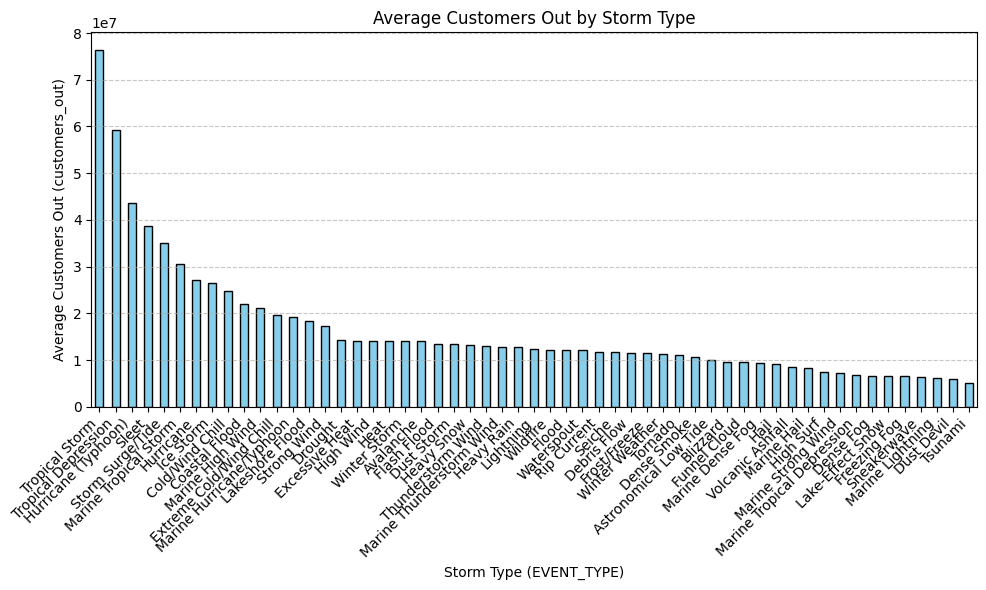

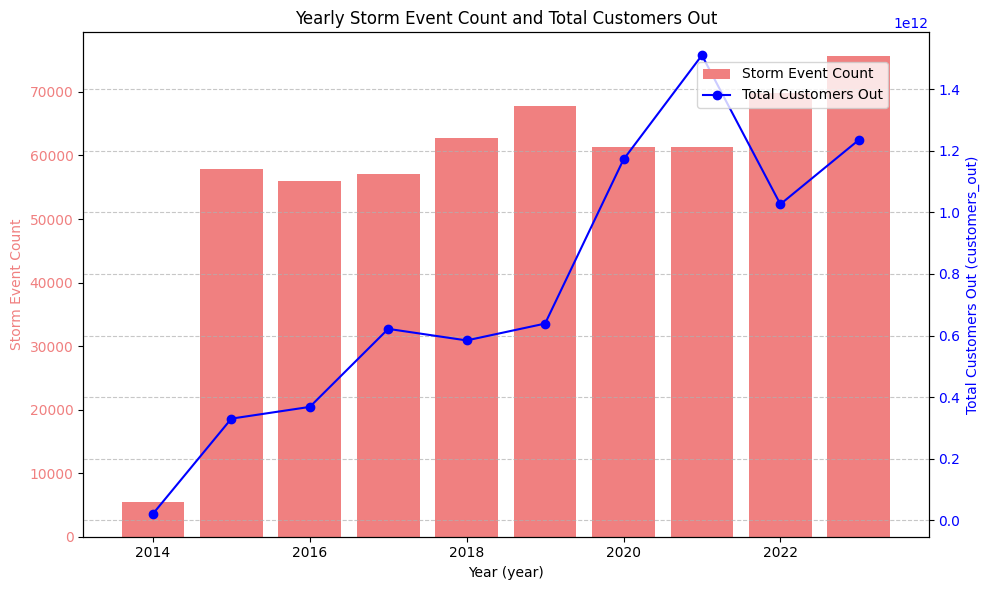

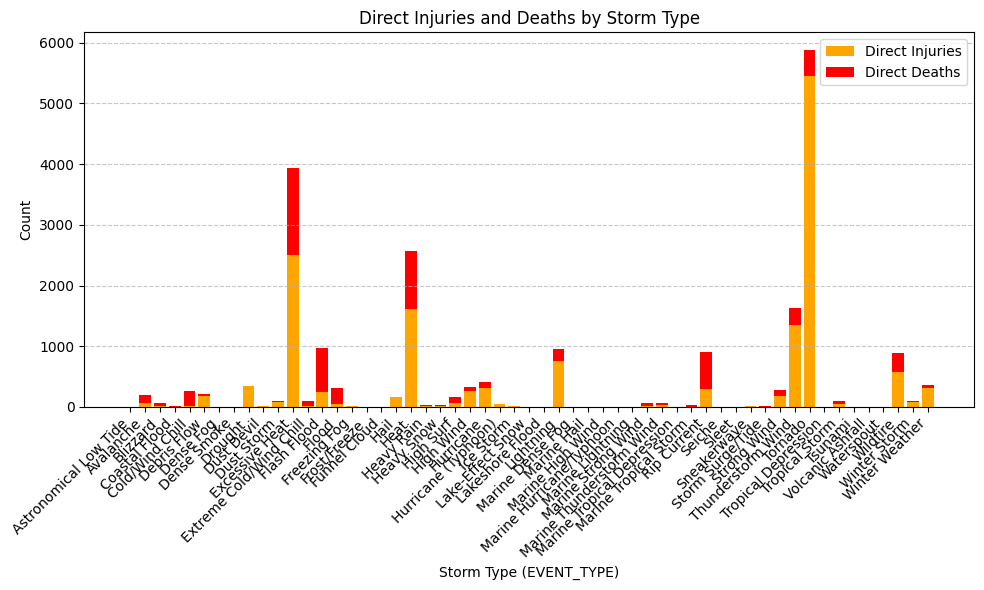

Columns in merged_df_cleaned: ['date', 'customers_out', 'year', 'EPISODE_ID', 'EVENT_ID', 'EVENT_TYPE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE']


In [41]:


# Visualization 1: Bar Chart of Average customers_out by EVENT_TYPE
event_type_avg = merged_df_cleaned.groupby('EVENT_TYPE')['customers_out'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
event_type_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Customers Out by Storm Type')
plt.xlabel('Storm Type (EVENT_TYPE)')
plt.ylabel('Average Customers Out (customers_out)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Dual-Axis Plot of Yearly Storm Event Count and Total customers_out
yearly_stats = merged_df_cleaned.groupby('year').agg({
    'EVENT_ID': 'count',  # Count of storm events
    'customers_out': 'sum'  # Total customers out
}).reset_index()
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_stats['year'], yearly_stats['EVENT_ID'], color='lightcoral', label='Storm Event Count')
ax1.set_xlabel('Year (year)')
ax1.set_ylabel('Storm Event Count', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')
ax2 = ax1.twinx()
ax2.plot(yearly_stats['year'], yearly_stats['customers_out'], color='blue', marker='o', label='Total Customers Out')
ax2.set_ylabel('Total Customers Out (customers_out)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Yearly Storm Event Count and Total Customers Out')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Visualization 4: Stacked Bar Chart of INJURIES_DIRECT and DEATHS_DIRECT by EVENT_TYPE
injury_stats = merged_df_cleaned.groupby('EVENT_TYPE').agg({
    'INJURIES_DIRECT': 'sum',
    'DEATHS_DIRECT': 'sum'
}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(injury_stats['EVENT_TYPE'], injury_stats['INJURIES_DIRECT'], label='Direct Injuries', color='orange')
plt.bar(injury_stats['EVENT_TYPE'], injury_stats['DEATHS_DIRECT'], bottom=injury_stats['INJURIES_DIRECT'], label='Direct Deaths', color='red')
plt.title('Direct Injuries and Deaths by Storm Type')
plt.xlabel('Storm Type (EVENT_TYPE)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Print the columns of the cleaned DataFrame for reference
print("Columns in merged_df_cleaned:", merged_df_cleaned.columns.tolist())

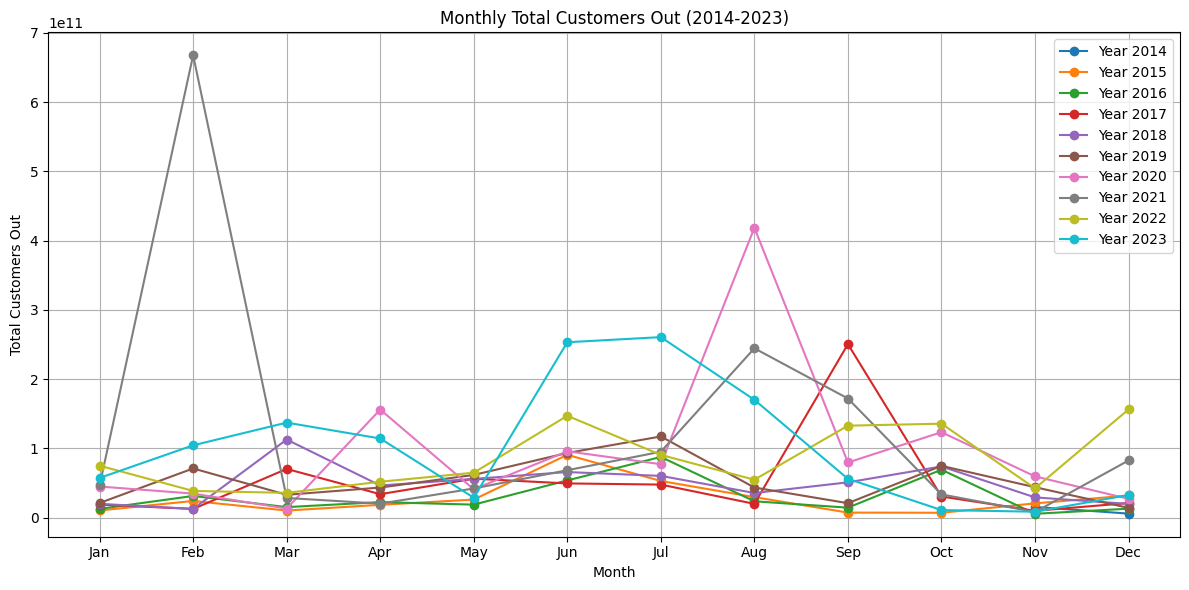

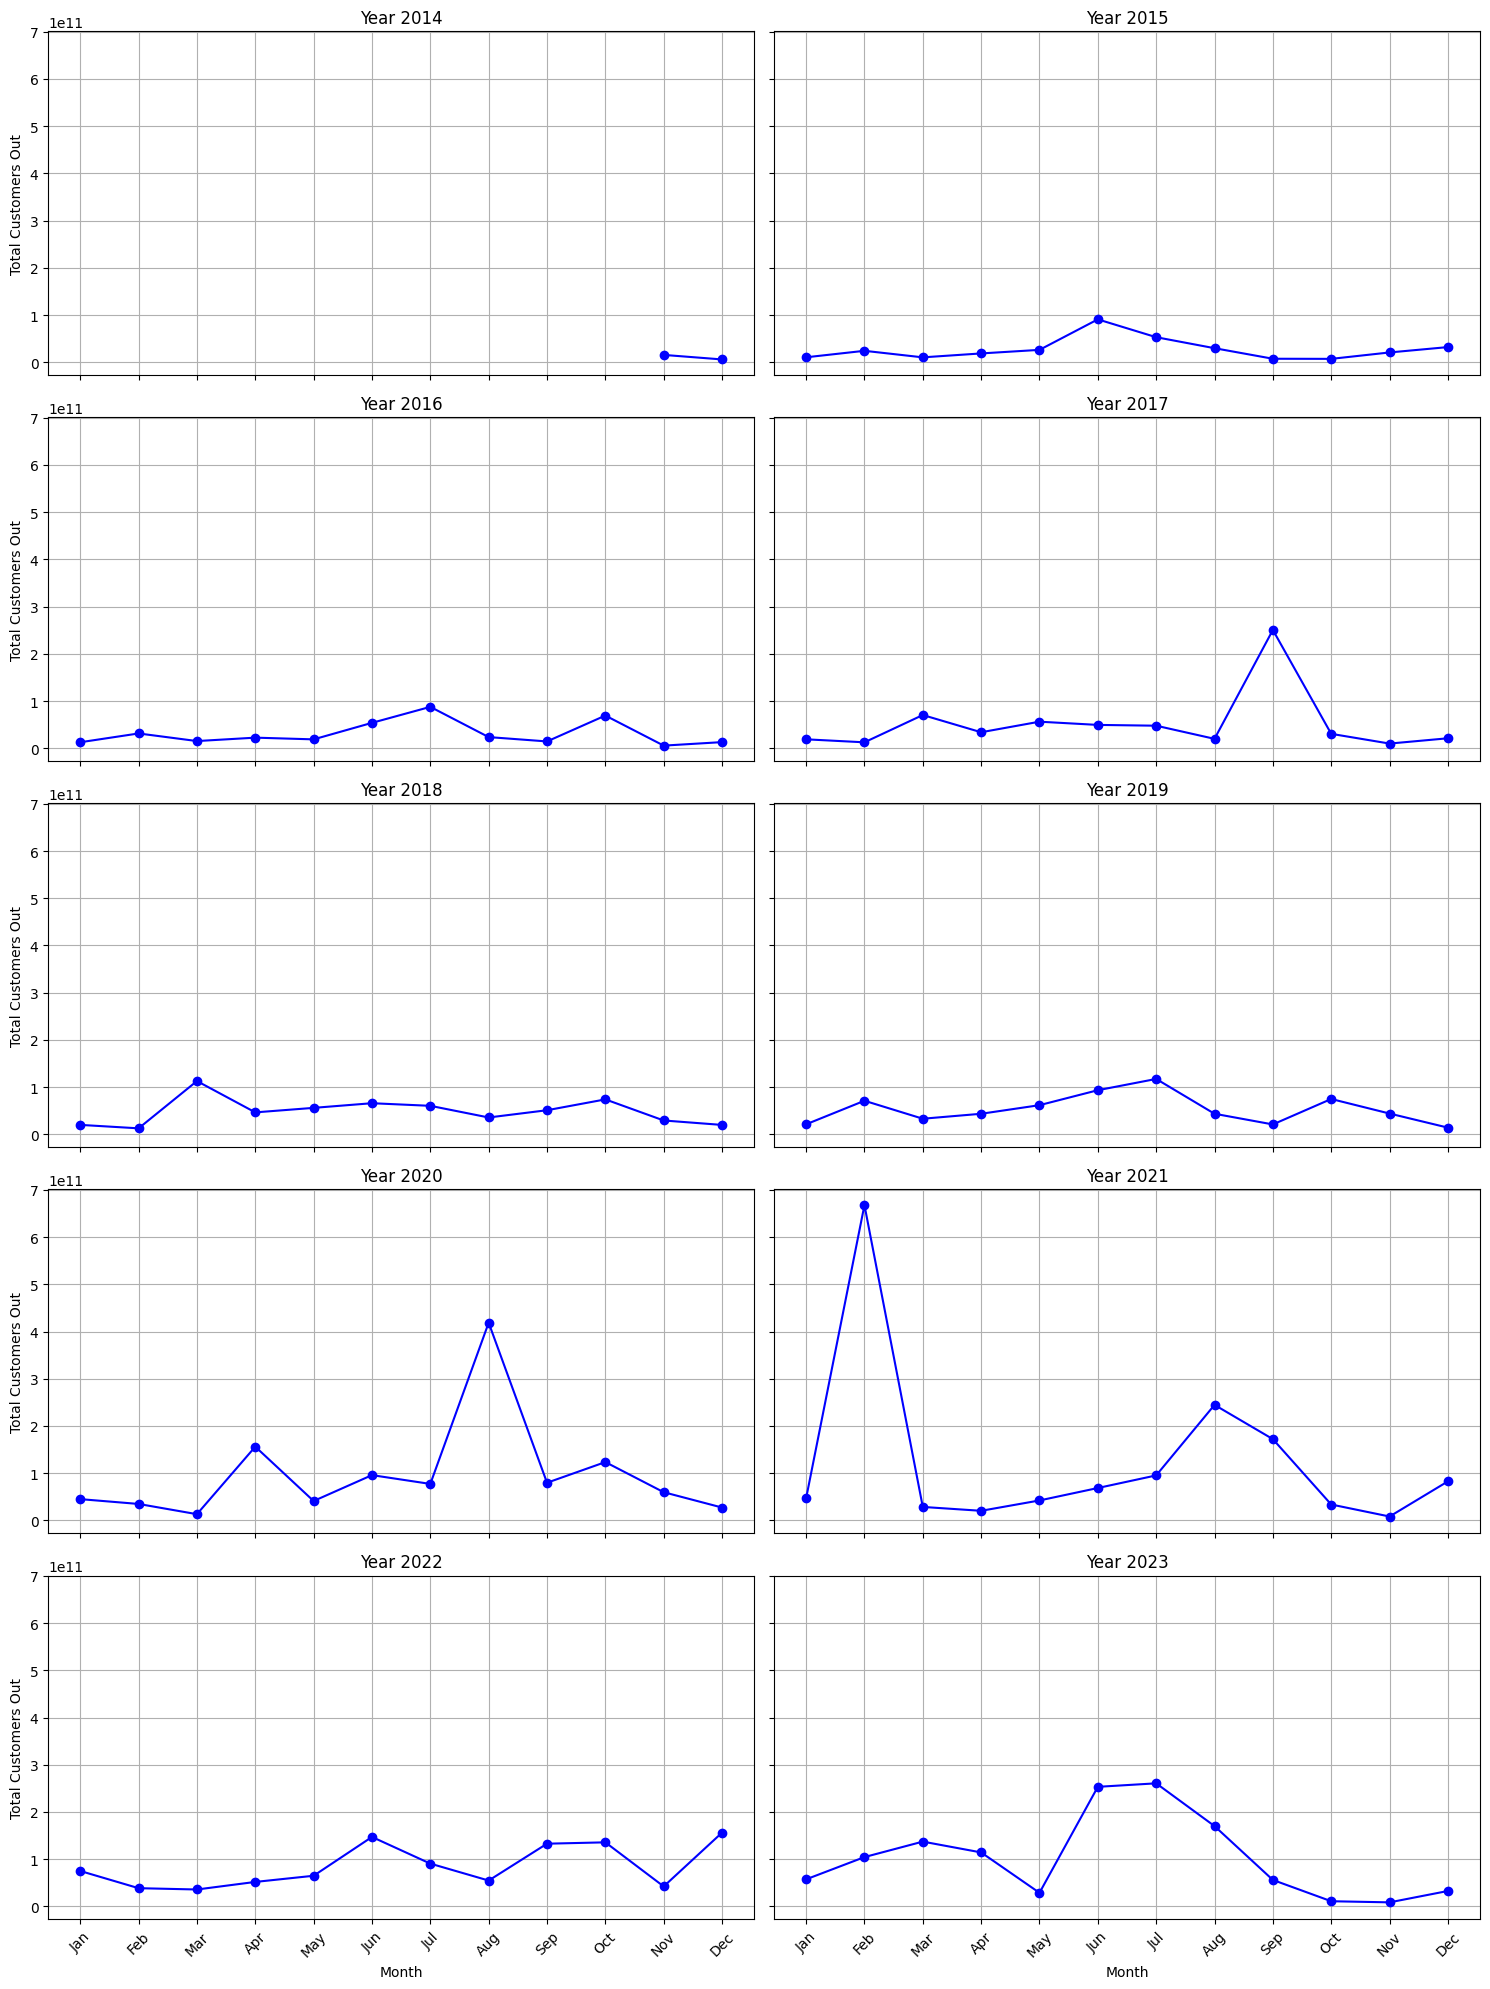

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is already created from previous steps
# It contains columns: date, customers_out, year, EVENT_TYPE, DAMAGE_PROPERTY, etc.

# Step 1: Prepare the data
# Extract month from date
merged_df['month'] = pd.to_datetime(merged_df['date']).dt.month

# Step 2: Figure 1 - Single Plot with All Years
plt.figure(figsize=(12, 6))
years = range(2014, 2024)
colors = sns.color_palette("tab10", len(years))  # Generate 10 distinct colors

for i, year in enumerate(years):
    year_data = merged_df[merged_df['year'] == year]
    if year_data.empty:
        continue
    monthly_customers_out = year_data.groupby('month')['customers_out'].sum()
    plt.plot(monthly_customers_out.index, monthly_customers_out.values, marker='o', color=colors[i], label=f'Year {year}')

plt.title('Monthly Total Customers Out (2014-2023)')
plt.xlabel('Month')
plt.ylabel('Total Customers Out')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Figure 2 - 5x2 Subplots for Each Year
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 5x2 array for easier indexing

for i, year in enumerate(years):
    year_data = merged_df[merged_df['year'] == year]
    if year_data.empty:
        axes[i].set_title(f'Year {year}: No Data')
        continue
    monthly_customers_out = year_data.groupby('month')['customers_out'].sum()
    axes[i].plot(monthly_customers_out.index, monthly_customers_out.values, marker='o', color='blue')
    axes[i].set_title(f'Year {year}')
    axes[i].grid(True)

# Set labels for the bottom row and leftmost column
for ax in axes[-2:]:  # Bottom row
    ax.set_xlabel('Month')
for ax in axes[::2]:  # Leftmost column
    ax.set_ylabel('Total Customers Out')

# Set x-ticks to month names
for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# # Step 1: Load and group data by county and state
# years = range(2014, 2024)
# dfs = []

# for year in years:
#     print(f"Processing year {year}...")
#     file_path = f'eaglei_outages_{year}.csv'
#     try:
#         df = pd.read_csv(elec_path+file_path)
#     except FileNotFoundError:
#         print(f"File for year {year} not found. Skipping...")
#         continue
    
#     # Add year column
#     df['year'] = year
    
#     # Append to list
#     dfs.append(df)

# # Concatenate all DataFrames
# if not dfs:
#     raise ValueError("No data was processed. Check if the files exist.")
# combined_df = pd.concat(dfs, ignore_index=True)

# # Group by county and state, summing customers_out
# county_grouped = combined_df.groupby(['county', 'state'])['customers_out'].sum().reset_index()

# # For yearly trends, we also need to group by county, state, and year
# county_yearly = combined_df.groupby(['county', 'state', 'year'])['customers_out'].sum().reset_index()

# # Step 2: Visualizations

# # Visualization 1: Bar Chart of Top 10 Counties by Total customers_out
# top_counties = county_grouped.sort_values(by='customers_out', ascending=False).head(10)
# plt.figure(figsize=(10, 6))
# plt.bar(top_counties['county'] + ', ' + top_counties['state'], top_counties['customers_out'], color='skyblue', edgecolor='black')
# plt.title('Top 10 Counties by Total Customers Out (2014-2023)')
# plt.xlabel('County, State')
# plt.ylabel('Total Customers Out')
# plt.xticks(rotation=45, ha='right')
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # Visualization 2: Pie Chart of Top 5 States by Total customers_out
# state_grouped = combined_df.groupby('state')['customers_out'].sum().sort_values(ascending=False).head(5)
# plt.figure(figsize=(8, 8))
# plt.pie(state_grouped, labels=state_grouped.index, autopct='%1.1f%%', colors=sns.color_palette('pastel', len(state_grouped)))
# plt.title('Top 5 States by Total Customers Out (2014-2023)')
# plt.tight_layout()
# plt.show()

# # Visualization 3: Yearly Trend of customers_out for Top 5 Counties
# top_5_counties = county_grouped.sort_values(by='customers_out', ascending=False).head(5)[['county', 'state']].values
# plt.figure(figsize=(12, 6))
# colors = sns.color_palette("tab10", len(top_5_counties))

# for i, (county, state) in enumerate(top_5_counties):
#     county_data = county_yearly[(county_yearly['county'] == county) & (county_yearly['state'] == state)]
#     plt.plot(county_data['year'], county_data['customers_out'], marker='o', color=colors[i], label=f'{county}, {state}')

# plt.title('Yearly Trend of Customers Out for Top 5 Counties (2014-2023)')
# plt.xlabel('Year')
# plt.ylabel('Total Customers Out')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...
Processing year 2022...
Processing year 2023...


: 

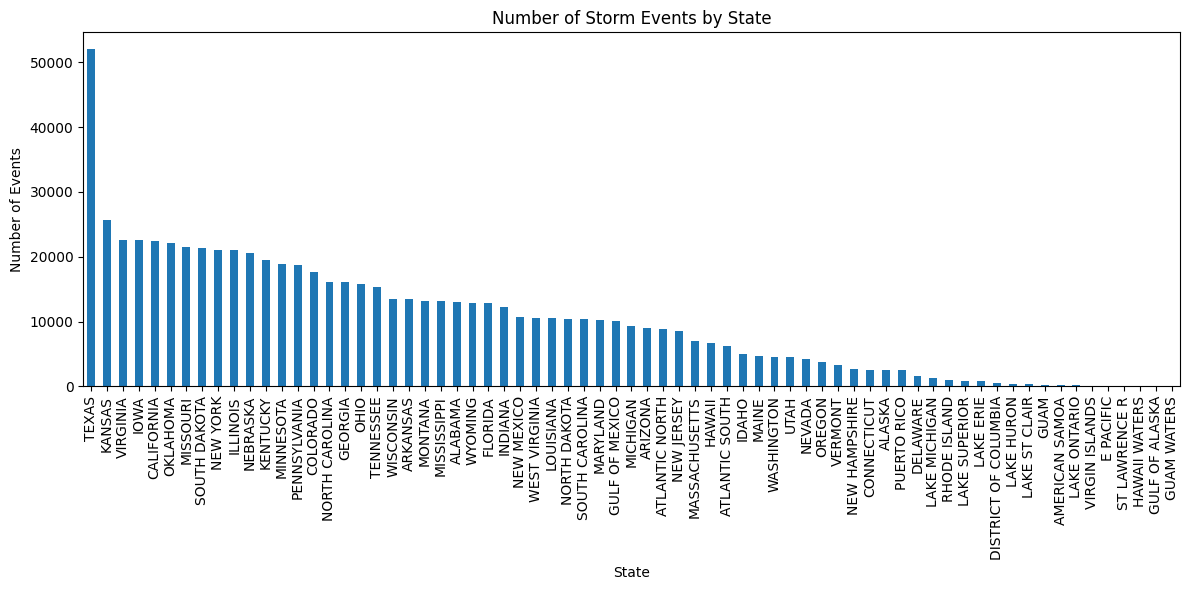

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# plt.style.use('seaborn')

state_counts = storms_df['STATE'].value_counts()

plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.title('Number of Storm Events by State')
plt.xlabel('State')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

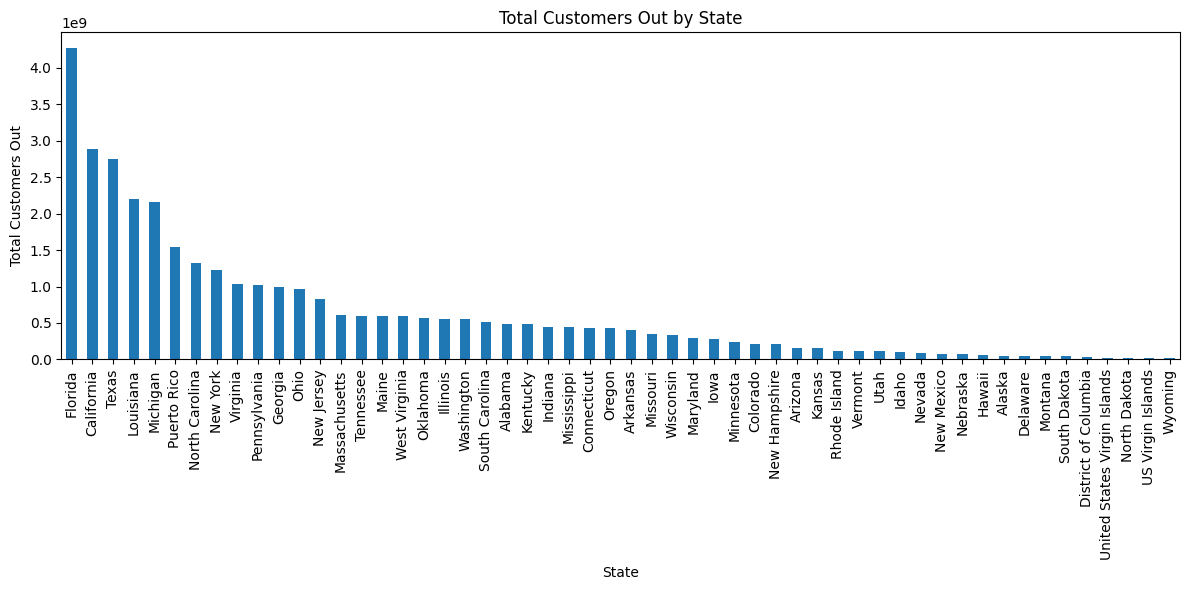

In [36]:
state_outages = eaglei.groupby('state')['customers_out'].sum().sort_values(ascending=False)

# 绘制柱状图
plt.figure(figsize=(12, 6))
state_outages.plot(kind='bar')
plt.title('Total Customers Out by State')
plt.xlabel('State')
plt.ylabel('Total Customers Out')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()